In [ ]:
import numpy as np
import csv
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

In [ ]:
import camera_tools as ct

In [ ]:
from cmac2 import CMAC

In [ ]:
#Calibrate the camera to detect green box, if you haven't done this calibration before
low_green, high_green = ct.colorpicker()
print(low_green)
print(high_green)

In [ ]:
low_green = np.array([51, 70, 93])
high_green = np.array([120,103,208])

In [ ]:
#Check whether the camera detects the green object properly
cam = ct.prepare_camera()
image = ct.capture_image(cam)
x,y = ct.locate(image, low_green, high_green)
ct.show_camera(cam)

print(x,y)

In [ ]:
from FableAPI.fable_init import api
api.setup(blocking=True)

In [ ]:
moduleids = api.discoverModules()
print("Module IDs: ", moduleids)
moduleID = moduleids[0]
print("Battery level:",api.getBattery(moduleID),"%")

In [ ]:
A = 120
T = 50

In [ ]:
api.setPos(-90,0,moduleID)

In [ ]:
#Now integrate the CMAC to the previous control loop which had only the Neural Network. 
#The implementation of the CMAC can be found in code given for second week exercises.
#TODO: Implement the control loop with both neural network and CMAC. 
def ControlLoopWithBothNNandCMAC(target_x, target_y, iter_num):
    
    # api.setPos(-90,90,moduleID)
    target_x_coord = target_x
    target_y_coord = target_y

    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    max_iter = iter_num

    ## TODO: CMAC initialization
    n_rfs = 5
    beta = 1

    xmin = [152,152]
    xmax = [480, 480]

    c = CMAC(n_rfs, xmin, xmax, beta)

    # P-controller
    Kp = 0.02
    Kd = 0.0

    x = 0
    y = 0

    x_coord_error = 0

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)
        # print(x,y)

        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)

        x_ref = A * np.sin(2*np.pi * i/T) + 300
        # x_ref = 400
        y_ref = y

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        print(i, x, x_ref)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        x_error_prev = x_coord_error
       
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;

        x_error_div = x_coord_error - x_error_prev

        # print("x_error_div = ", x_error_div)
        
        ## TODO: Implement the CMAC controller into the loop
        x_cmac = [x_ref ,robot_x_coord_in_image]
        angle_cmac = c.predict(x_cmac)

        # print(x_cmac)        
    
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break

        p_out = - Kp * x_coord_error - Kd*x_error_div
        # print("p_out = ", p_out)
       
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + p_out
        
        c.learn(p_out)
        print(angle_cmac)
        robot_nn_and_cmac = robot_next_Y_pos + angle_cmac

        # print("robot_next_Y_pos = ", robot_next_Y_pos)

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_nn_and_cmac,moduleID)
        api.sleep(0.7)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]

[x_ref_vec,x_act_vec] = ControlLoopWithBothNNandCMAC(0,0, 40)
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()

In [161]:
api.setPos(-90,90,moduleID)

0

0 110 400.0
0.0
1 108 400.0
0.0
2 112 400.0
0.0
3 112 400.0
0.0
4 112 400.0
6.582037165301817e-06
5 114 400.0
5.195121920537441e-05
6 120 400.0
0.0002122569351730735
7 128 400.0
0.0006196008635566426
8 140 400.0
0.0014690468598431467
9 152 400.0
0.0030073963965600997
10 166 400.0
0.005537040200054554
11 182 400.0
0.009378315176685149
12 198 400.0
0.014839786295604656
13 214 400.0
0.022220630224767605
14 228 400.0
0.031772777279232715
15 246 400.0
0.04376175306592119
16 260 400.0
0.05811511389117334
17 272 400.0
0.07502290363884408
18 282 400.0
0.09457926863131733
19 288 400.0
0.11689563597182259
20 298 400.0
0.142386080560828
21 304 400.0
0.17048033985167782
22 312 400.0
0.20163608106363184
23 316 400.0
0.2353392407082981
24 320 400.0
0.2722591145714747
25 324 400.0
0.31234068020087286
26 332 400.0
0.35550334278985285
27 336 400.0
0.40021629378575474
28 340 400.0
0.44747815622406034
29 345 400.0
0.49703835683380626
30 350 400.0
0.5481443959168341
31 353 400.0
0.600366417660295
32 355 4

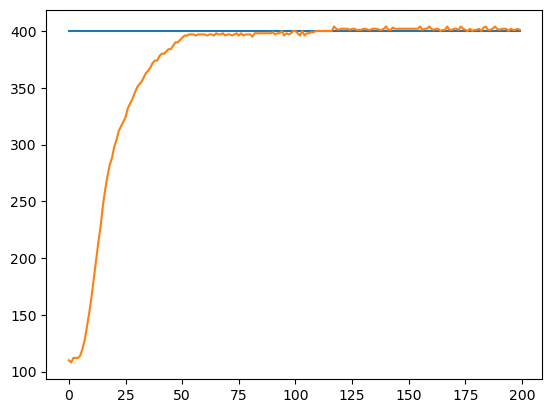

In [162]:
from adaptive_filter.cerebellum import AdaptiveFilterCerebellum


def AFwithP(target_x, target_y, iter_num):
    
    # api.setPos(-90,90,moduleID)
    target_x_coord = target_x
    target_y_coord = target_y

    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    max_iter = iter_num

   ## TODO: AF initialization
    Ts = 1e-4
    n_inputs = 1
    n_outputs = 1
    n_bases = 20
    beta = 1

    af = AdaptiveFilterCerebellum(Ts, n_inputs, n_outputs, n_bases, beta)

    # P-controller
    Kp = 0.02
    Kd = 0.0

    x = 0
    y = 0

    x_coord_error = 0
    robot_input = 0

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)
        # print(x,y)

        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)

        # x_ref = A * np.sin(2*np.pi * i/T) + 300
        x_ref = 400
        y_ref = y

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        print(i, x, x_ref)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        x_error_prev = x_coord_error
       
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;

        x_error_div = x_coord_error - x_error_prev

        # print("x_error_div = ", x_error_div)
        
        ## TODO: Implement the CMAC controller into the loop
        af_out = af.step(robot_input, x_coord_error)
        print(af_out)
        x_coord_error = x_coord_error + af_out

        # print(x_cmac)        
    
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break

        p_out = - Kp * x_coord_error - Kd*x_error_div
        # print("p_out = ", p_out)
       
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + p_out

        # print("robot_next_Y_pos = ", robot_next_Y_pos)
        robot_input = p_out

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_next_Y_pos,moduleID)
        api.sleep(0.7)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]

[x_ref_vec,x_act_vec] = AFwithP(0,0, 200)
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()